In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import umap

c:\Users\xenov\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = pd.read_csv("customer_segmentation_project.csv", encoding='ISO-8859-1')
data = data.dropna(subset=['CustomerID', 'Description'])  # удаляем строки без клиента/описания
data = data.drop_duplicates()

data = data[(data['Quantity'] != 0) & (data['UnitPrice'] != 0)]

data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])

data['TotalPrice'] = data['Quantity'] * data['UnitPrice']

In [3]:
reference_date = data['InvoiceDate'].max() + timedelta(days=1)

sales_data = data[~data['InvoiceNo'].str.startswith('C')]

rfm = sales_data.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda x: (reference_date - x.max()).days),
    Frequency=('InvoiceNo', 'nunique')
).reset_index()

monetary = data.groupby('CustomerID').agg(Monetary=('TotalPrice', 'sum')).reset_index()

rfm = pd.merge(rfm, monetary, on='CustomerID')


In [4]:
rfm_filtered = rfm[(rfm['Frequency'] <= 30) & (rfm['Monetary'] <= 20000)].copy()


In [5]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_filtered[['Recency', 'Frequency', 'Monetary']])


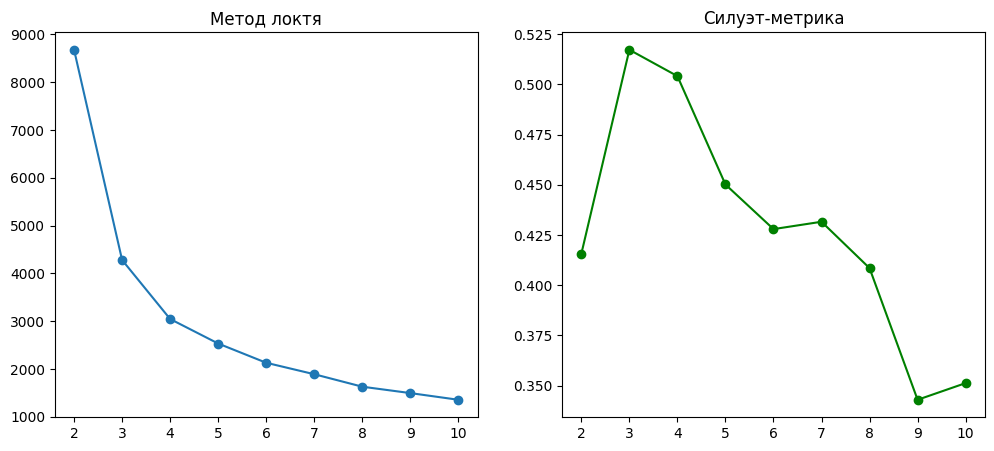

Оптимальное количество кластеров: 3


In [6]:
inertias = []
silhouettes = []
Ks = range(2, 11)

for k in Ks:
    model = KMeans(n_clusters=k, random_state=42)
    labels = model.fit_predict(rfm_scaled)
    inertias.append(model.inertia_)
    silhouettes.append(silhouette_score(rfm_scaled, labels))

# Графики
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(Ks, inertias, marker='o')
plt.title('Метод локтя')

plt.subplot(1,2,2)
plt.plot(Ks, silhouettes, marker='o', color='green')
plt.title('Силуэт-метрика')
plt.show()

# Лучшее значение K
optimal_k = Ks[np.argmax(silhouettes)]
print(f"Оптимальное количество кластеров: {optimal_k}")


In [7]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
rfm_filtered['Cluster'] = kmeans.fit_predict(rfm_scaled)

print(rfm_filtered['Cluster'].value_counts())


Cluster
0    2824
1    1072
2     383
Name: count, dtype: int64


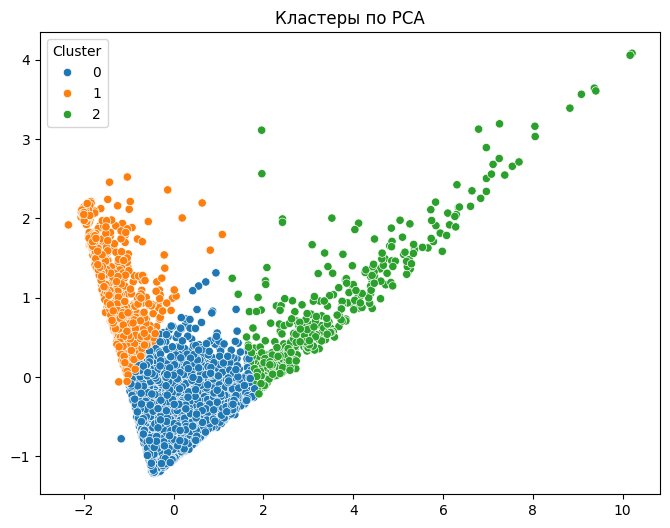

c:\Users\xenov\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\xenov\AppData\Local\Programs\Python\Python313\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


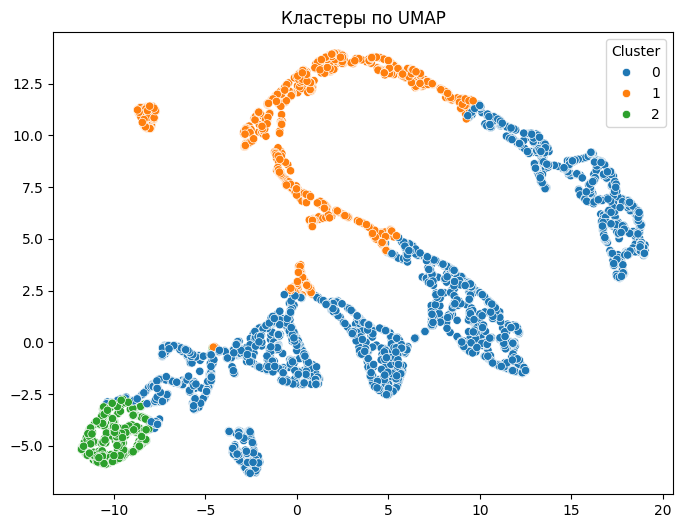

In [8]:
# PCA
pca = PCA(n_components=2)
pca_coords = pca.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_coords[:,0], y=pca_coords[:,1], hue=rfm_filtered['Cluster'], palette='tab10')
plt.title("Кластеры по PCA")
plt.show()

# UMAP
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
umap_coords = reducer.fit_transform(rfm_scaled)

plt.figure(figsize=(8,6))
sns.scatterplot(x=umap_coords[:,0], y=umap_coords[:,1], hue=rfm_filtered['Cluster'], palette='tab10')
plt.title("Кластеры по UMAP")
plt.show()


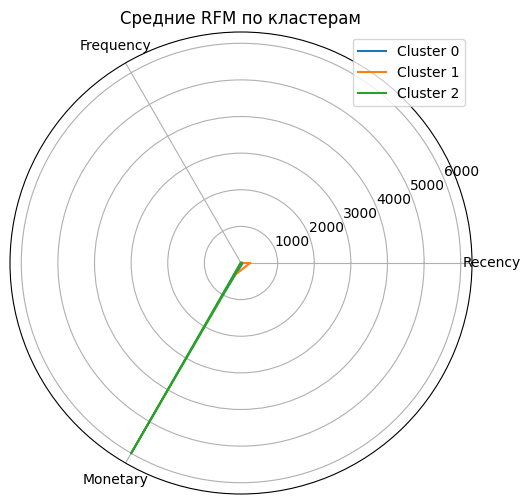

In [9]:
summary = rfm_filtered.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'CustomerID': 'count'
}).rename(columns={'CustomerID': 'Clients'}).round(1)

# Радарный график
categories = ['Recency', 'Frequency', 'Monetary']
angles = [n / float(len(categories)) * 2 * np.pi for n in range(len(categories))]
angles += [angles[0]]

plt.figure(figsize=(6,6))
ax = plt.subplot(111, polar=True)

for i, row in summary.iterrows():
    values = row[categories].tolist()
    values += [values[0]]
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

plt.xticks(angles[:-1], categories)
plt.title("Средние RFM по кластерам")
plt.legend(loc='upper right')
plt.show()
